# Visualize Mask Only
Following Notebook demos how to display colored mask only.

In [20]:
import os
import sys
import random
import math
import re
import time
import numpy as np
import cv2
import matplotlib
import matplotlib.pyplot as plt

# Root directory of the project
ROOT_DIR = os.path.abspath("../../")

# Import Mask RCNN
sys.path.append(ROOT_DIR)  # To find local version of the library
from mrcnn.config import Config
from mrcnn import utils
import mrcnn.model as modellib
from mrcnn import visualize
from mrcnn.model import log

from pycocotools.coco import COCO

%matplotlib inline 

# Directory to save logs and trained model
MODEL_DIR = os.path.join(ROOT_DIR, "logs")

# Local path to trained weights file
COCO_MODEL_PATH = os.path.join(ROOT_DIR, "mask_rcnn_coco.h5")
# Download COCO trained weights from Releases if needed
if not os.path.exists(COCO_MODEL_PATH):
    utils.download_trained_weights(COCO_MODEL_PATH)

## Configurations

In [21]:
class TestConfig(Config):
    """Configuration for training on the toy shapes dataset.
    Derives from the base Config class and overrides values specific
    to the toy shapes dataset.
    """
    # Give the configuration a recognizable name
    NAME = "fashion"

    # Train on 1 GPU and 8 images per GPU. We can put multiple images on each
    # GPU because the images are small. Batch size is 8 (GPUs * images/GPU).
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

    # Number of classes (including background)
    NUM_CLASSES = 1 + 13  # background + 13 shapes

    # Use small images for faster training. Set the limits of the small side
    # the large side, and that determines the image shape.
    IMAGE_MIN_DIM = 256
    IMAGE_MAX_DIM = 256

    # Use smaller anchors because our image and objects are small
    RPN_ANCHOR_SCALES = (8, 16, 32, 64, 128)  # anchor side in pixels

    # Reduce training ROIs per image because the images are small and have
    # few objects. Aim to allow ROI sampling to pick 33% positive ROIs.
    TRAIN_ROIS_PER_IMAGE = 32

    # Use a small epoch since the data is simple
    STEPS_PER_EPOCH = 10

    # use small validation steps since the epoch is small
    VALIDATION_STEPS = 5

## Notebook Preferences

In [22]:
def get_ax(rows=1, cols=1, size=8):
    """Return a Matplotlib Axes array to be used in
    all visualizations in the notebook. Provide a
    central point to control graph sizes.
    
    Change the default size attribute to control the size
    of rendered images
    """
    _, ax = plt.subplots(rows, cols, figsize=(size*cols, size*rows))
    return ax

## Dataset
Raw dataset related.

In [23]:
import io
import lmdb
import sqlite3
import pandas as pd
import json
from PIL import Image
from IPython.display import display

In [24]:
class PhotoData(object):
    def __init__(self, path):
        self.env = lmdb.open(
            path, map_size=2**36, readonly=True, lock=False
        )
        
    def __iter__(self):
        with self.env.begin() as t:
            with t.cursor() as c:
                for key, value in c:
                    yield key, value
        
    def __getitem__(self, index):
        key = str(index).encode('ascii')
        with self.env.begin() as t:
            data = t.get(key)
        if not data:
            return None
        with io.BytesIO(data) as f:
            image = Image.open(f)
            image.load()
            return image
        
    def __len__(self):
        return self.env.stat()['entries']

photo_data = PhotoData(r'..'+os.path.sep+'..'+os.path.sep+'..'+os.path.sep+'photos.lmdb')

# Fashion Dataset Class
Extend the Dataset class and add a method to load the shapes dataset, `load_shapes()`, and override the following methods:

* load_image()
* load_mask()
* image_reference()

## Detection

In [15]:
json_file = r'..' + os.path.sep + '..' + os.path.sep + '..' + os.path.sep + 'modanet2018_instances_train.json'
d = json.load(open(json_file))
coco=COCO(json_file)
subset = sorted(coco.getCatIds(catNms=['bag', 'belt', 'outer', 'dress', 'pants', 'top', 'shorts', 'skirt', 'scarf/tie']))
test_config = TestConfig()
# Recreate the model in inference mode
model = modellib.MaskRCNN(mode="inference", 
                          config=test_config,
                          model_dir=MODEL_DIR)
# Get path to saved weights
# Either set a specific path or find last trained weights
# model_path = os.path.join(ROOT_DIR, ".h5 file name here")
model_path = model.find_last()

# Load trained weights
print("Loading weights from ", model_path)
model.load_weights(model_path, by_name=True)

loading annotations into memory...
Done (t=3.89s)
creating index...
index created!
Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
Loading weights from  C:\Training\DeepLearningGit\virtualFitting\mask_rcnn\logs\fashion20190607T0740\mask_rcnn_fashion_0200.h5
Re-starting from epoch 200


In [25]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

<class 'numpy.ndarray'>
Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 26)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16368, 4)         min:   -0.35494  max:    1.10396  float32


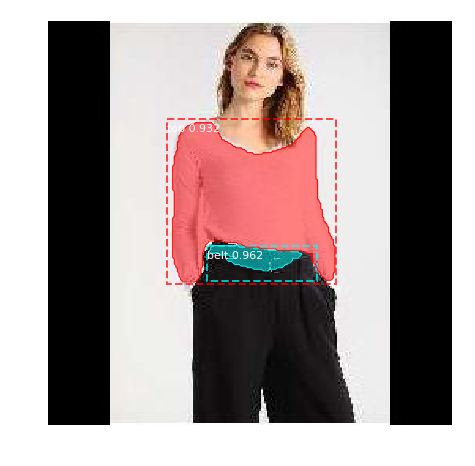

In [26]:
import PIL
import numpy as np
from PIL import Image, ImageOps

desired_size = 256
# im = img
im_pth = "target1.jpg"
# im_pth = 'jeans.jpg'
im = Image.open(im_pth)
old_size = im.size  # old_size[0] is in (width, height) format

ratio = float(desired_size)/max(old_size)
new_size = tuple([int(x*ratio) for x in old_size])

im = im.resize(new_size, Image.ANTIALIAS)
# create a new image and paste the resized on it

new_im = Image.new("RGB", (desired_size, desired_size))
new_im.paste(im, ((desired_size-new_size[0])//2,
                    (desired_size-new_size[1])//2))

new_im.save('resized_new_im.jpg')
# new_im.show()

im = np.asarray(PIL.Image.open('resized_new_im.jpg'))
print(type(im))

results = model.detect([im], verbose=1)
r = results[0]
visualize.display_instances(im, r['rois'], r['masks'], r['class_ids'], 
                            dataset_test.class_names, r['scores'], ax=get_ax())

Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 26)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16368, 4)         min:   -0.35494  max:    1.10396  float32


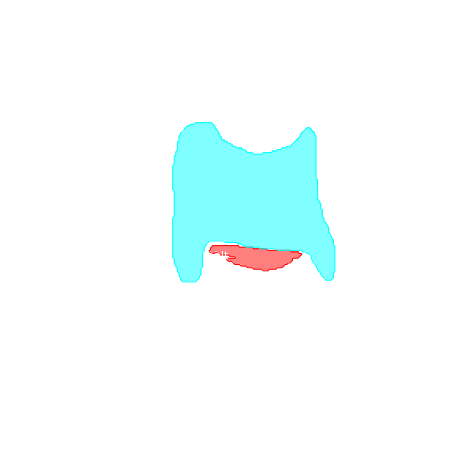

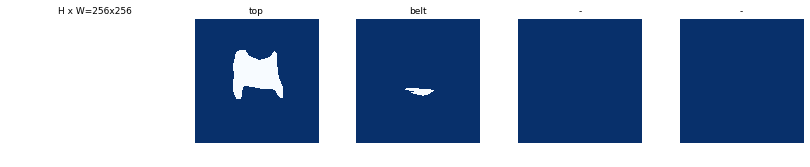

In [27]:
background = np.zeros([256,256,3],dtype=np.uint8)
background.fill(255) # or img[:] = 255

results = model.detect([im], verbose=1)
r = results[0]
# visualize.display_instances(background, r['rois'], r['masks'], r['class_ids'], 
#                             dataset_test.class_names, r['scores'], ax=get_ax())
visualize.display_instances(background, r['rois'], r['masks'], r['class_ids'], 
                            dataset_test.class_names, ax=get_ax(), show_bbox=False)
visualize.display_top_masks(background, r['masks'], r['class_ids'], dataset_test.class_names)